# Vertex AI: Qwik Start

## Learning objectives

* Train a TensorFlow model locally in a hosted [**Vertex Notebook**](https://cloud.google.com/vertex-ai/docs/general/notebooks?hl=sv).
* Create a [**managed Tabular dataset**](https://cloud.google.com/vertex-ai/docs/training/using-managed-datasets?hl=sv) artifact for experiment tracking.
* Containerize your training code with [**Cloud Build**](https://cloud.google.com/build) and push it to [**Google Cloud Container Registry**](https://cloud.google.com/container-registry).
* Run a [**Vertex AI custom training job**]() with your custom model container.
* Use [**Vertex TensorBoard**](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) to visualize model performance.
* Deploy your trained model to a [**Vertex Prediction Endpoint**](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) for serving predictions.
* Request an online prediction and see the response.

## Introduction: customer lifetime value (CLV) prediction with BigQuery and TensorFlow on Vertex AI

In this lab, you will use BigQuery for data processing and exploratory data analysis and Vertex AI to train and deploy a custom TensorFlow Regressor model to predict customer lifetime value.

CLV is a customer's past value plus their predicted future value. The goal of predictive CLV is to calculate how much monetary value a user will bring to the business in a given future time range.

By knowing CLTV, you can develop positive ROI strategies and make decisions about how much money to invest in acquiring new customers and retaining existing ones.

Once your ML model is a success, you can use the results to identify the category of customers more likely to spend money than the others, and make them respond to your offers and discounts with a greater frequency. These customers, with higher loyalty, are your main marketing target.

By using the approaches described in this series to predict your customers' value, you can prioritize your next actions, such as the following:

* Decide how much to invest in advertising.
* Decide which customers to target with advertising.
* Plan how to move customers from one segment to another.

## Predictive CLV: how much monetary value an existing customer will bring to the business in the future

Your task is to predict the future value for existing customers based on their known transaction history.

![CLV](./images/clv-rfm.svg "Customer Lifetime Value")

* **Recency**: The time between the last purchase and today, represented by the distance between the rightmost circle and the vertical dotted line that's labeled "Now".
* **Frequency**: The time between purchases, represented by the distance between the circles on a single line.
* **Monetary**: The amount of money spent on each purchase, represented by the size of the circle. This amount could be the average order value or the quantity of products that the customer ordered.

## Setup

### Define constants

In [2]:
# Add installed depedencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [3]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1'

In [4]:
# Create Google Cloud Storage bucket for artifact storage.
BUCKET_NAME = f"gs://{PROJECT_ID}-bucket"
print(BUCKET_NAME)

gs://dougkelly-vertex-demos-bucket


In [ ]:
MODEL_NAME = "online-retail-clv"

### Import libraries

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from google.cloud import aiplatform

### Initialize the Vertex Python SDK client

Import the Vertex SDK for Python into your Python environment and initialize it.

In [ ]:
aiplatform.init(project=PROJECT_ID, region=REGION, staging_bucket=BUCKET_NAME)

## Exploratory data analysis (EDA) in BigQuery

### Dataset

In this lab, you will use the publicly available [Online Retail data set](https://archive.ics.uci.edu/ml/datasets/online+retail) from the UCI Machine Learning Repository. This dataset contains 541,909 transnational customer transactions occuring between (YYYY-MM-DD) 2010-12-01 and 2011-12-09 for a UK-based and registered non-store retailer. The company mainly sells unique all-occasion gifts. Many of the company's customers are wholesalers.

**Citation**  
Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.

This lab is inspired by the Google Cloud Architect Guide Series [Predicting Customer Lifetime Value with AI Platform: introduction](https://cloud.google.com/architecture/clv-prediction-with-offline-training-intro).

### Recency: how recently have customers purchased?

In [433]:
%%bigquery recency

SELECT
  days_since_last_purchase
FROM
`dougkelly-vertex-demos.online_retail.online_retail_clv_ml`

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2230.86rows/s]


In [434]:
recency.describe()

,days_since_last_purchase
count,3330.000000
mean,92.521021
std,77.240666
min,0.000000
25%,27.000000
50%,73.000000
75%,146.750000
max,274.000000


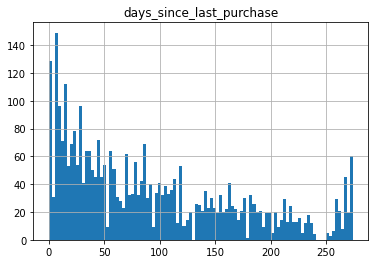

In [435]:
recency.hist(bins=100);

### Frequency: how often are customers purchasing?

In [429]:
%%bigquery frequency

SELECT
  n_purchases
FROM
`dougkelly-vertex-demos.online_retail.online_retail_clv_ml`

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2506.48rows/s]


In [430]:
frequency.describe()

,n_purchases
count,3330.000000
mean,3.134234
std,4.504362
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,81.000000


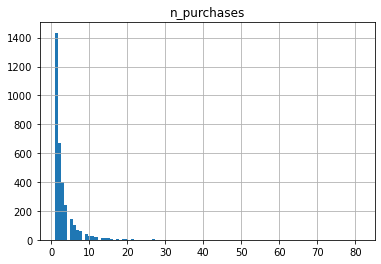

In [432]:
frequency.hist(bins=100);

### Q: Monetary

In [436]:
%%bigquery monetary

SELECT
  target_monetary_value_3M
FROM
`dougkelly-vertex-demos.online_retail.online_retail_clv_ml`

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2447.51rows/s]


In [437]:
monetary.describe()

,target_monetary_value_3M
count,3330.000000
mean,2355.838718
std,9445.870149
min,2.900000
25%,346.695000
50%,826.525000
75%,1977.495000
max,268478.000000


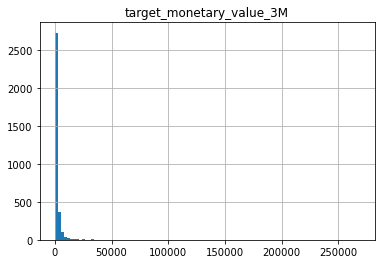

In [438]:
monetary.hist(bins=100);

### Establish a simple model performance baseline

In order to evaluate the performance of your custom TensorFlow DNN Regressor model you will build in the next steps, it is a good idea to establish a performance baseline. Below is a simple baseline that multiples a customer's average purchase spent by their daily

In [7]:
%%bigquery

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_ml`
  LEFT JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

SELECT
  ROUND(AVG(ABS(predicted_monetary_value_3M - target_monetary_value_3M)), 2) AS MAE,
  ROUND(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2)), 2) AS MSE,
  ROUND(SQRT(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2))), 2) AS RMSE
FROM
  predicted_clv

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.51s/rows]


,MAE,MSE,RMSE
0,1762.06,81502420.93,9027.87


In [8]:
%%bigquery baseline

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_ml`
  INNER JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

SELECT
 *
FROM
  predicted_clv

Downloading: 100%|██████████| 3324/3324 [00:01<00:00, 1843.05rows/s]


In [9]:
baseline.head()

,customer_id,predicted_monetary_value_3M,target_monetary_value_3M
0,14420.0,775.04,387.52
1,13099.0,414.72,207.36
2,12436.0,1018.02,509.01
3,13276.0,274.76,590.93
4,12739.0,1951.08,1013.04


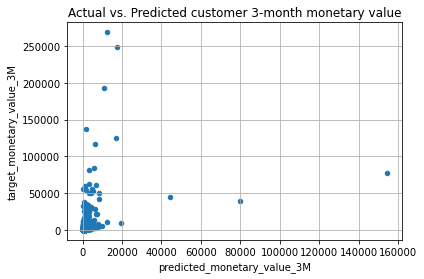

In [10]:
baseline.plot(kind='scatter',
              x='predicted_monetary_value_3M', 
              y='target_monetary_value_3M',
             title='Actual vs. Predicted customer 3-month monetary value',
             grid=True);

## Train a TensorFlow model locally

In [30]:
%%bigquery

SELECT data_split, COUNT(*)
FROM dougkelly-vertex-demos.online_retail.online_retail_clv_ml
GROUP BY data_split

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.26rows/s]


,data_split,f0_
0,TRAIN,2638
1,TEST,339
2,VALIDATE,353


In [586]:
%%bigquery clv

SELECT *
FROM dougkelly-vertex-demos.online_retail.online_retail_clv_ml

Downloading: 100%|██████████| 3330/3330 [00:01<00:00, 2243.38rows/s]


In [599]:
clv_train = clv.loc[clv.data_split == 'TRAIN', :]
clv_dev = clv.loc[clv.data_split == 'VALIDATE', :]
clv_test = clv.loc[clv.data_split == 'TEST', :]

In [588]:
# Model training constants.
# Virtual epochs design pattern:
# https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730
N_TRAIN_EXAMPLES = 2638
N_DEV_EXAMPLES = 353
STOP_POINT = 10.0
TOTAL_TRAIN_EXAMPLES = int(STOP_POINT * N_TRAIN_EXAMPLES)
BATCH_SIZE = 16
N_CHECKPOINTS = 10
STEPS_PER_EPOCH = (TOTAL_TRAIN_EXAMPLES // (BATCH_SIZE*N_CHECKPOINTS))

NUMERIC_FEATURES = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
]

CATEGORICAL_FEATURES = [
    "customer_country"
]

LABEL = "target_monetary_value_3M"

In [600]:
clv_train[LABEL].values

array([ 387.52,  207.36,  509.01, ..., 1141.24,  290.51,  216.76])

In [590]:
def df_dataset(df):
    label = df.pop(LABEL)
    return tf.data.Dataset.from_tensor_slices((df[NUMERIC_FEATURES].values, label.values))

In [591]:
trainds = df_dataset(clv_train).prefetch(1).batch(BATCH_SIZE).repeat()
evalds = df_dataset(clv_dev).prefetch(1).batch(BATCH_SIZE)
testds = df_dataset(clv_test)

In [592]:
feature_columns = [
    tf.feature_column.numeric_column(key=feature)
    for feature in NUMERIC_FEATURES
]

input_layers = {
  feature.key: tf.keras.layers.Input(name=feature.key, shape=(), dtype=tf.float32)
  for feature in feature_columns
}

In [593]:
# Create a custom RMSE evalution metric.
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model():
    """Build and compile a TensorFlow Keras Regressor."""
    # Keras Functional API: https://keras.io/guides/functional_api
    inputs = tf.keras.layers.DenseFeatures(feature_columns, name='inputs')(input_layers)
    d1 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name='d1')(inputs)
    d2 = tf.keras.layers.Dropout(0.1, name='d2')(d1)
    d3 = d1 = tf.keras.layers.Dense(32, activation=tf.nn.relu, name='d3')(d2)
    # Note: the single neuron output for regression.
    output = tf.keras.layers.Dense(1, name='output')(d3)
    
    model = tf.keras.Model(input_layers, output)
    
    optimizer = tf.keras.optimizers.Adam(0.01)    
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[['mae', 'mse', rmse]])
    
    return model

model = build_model()

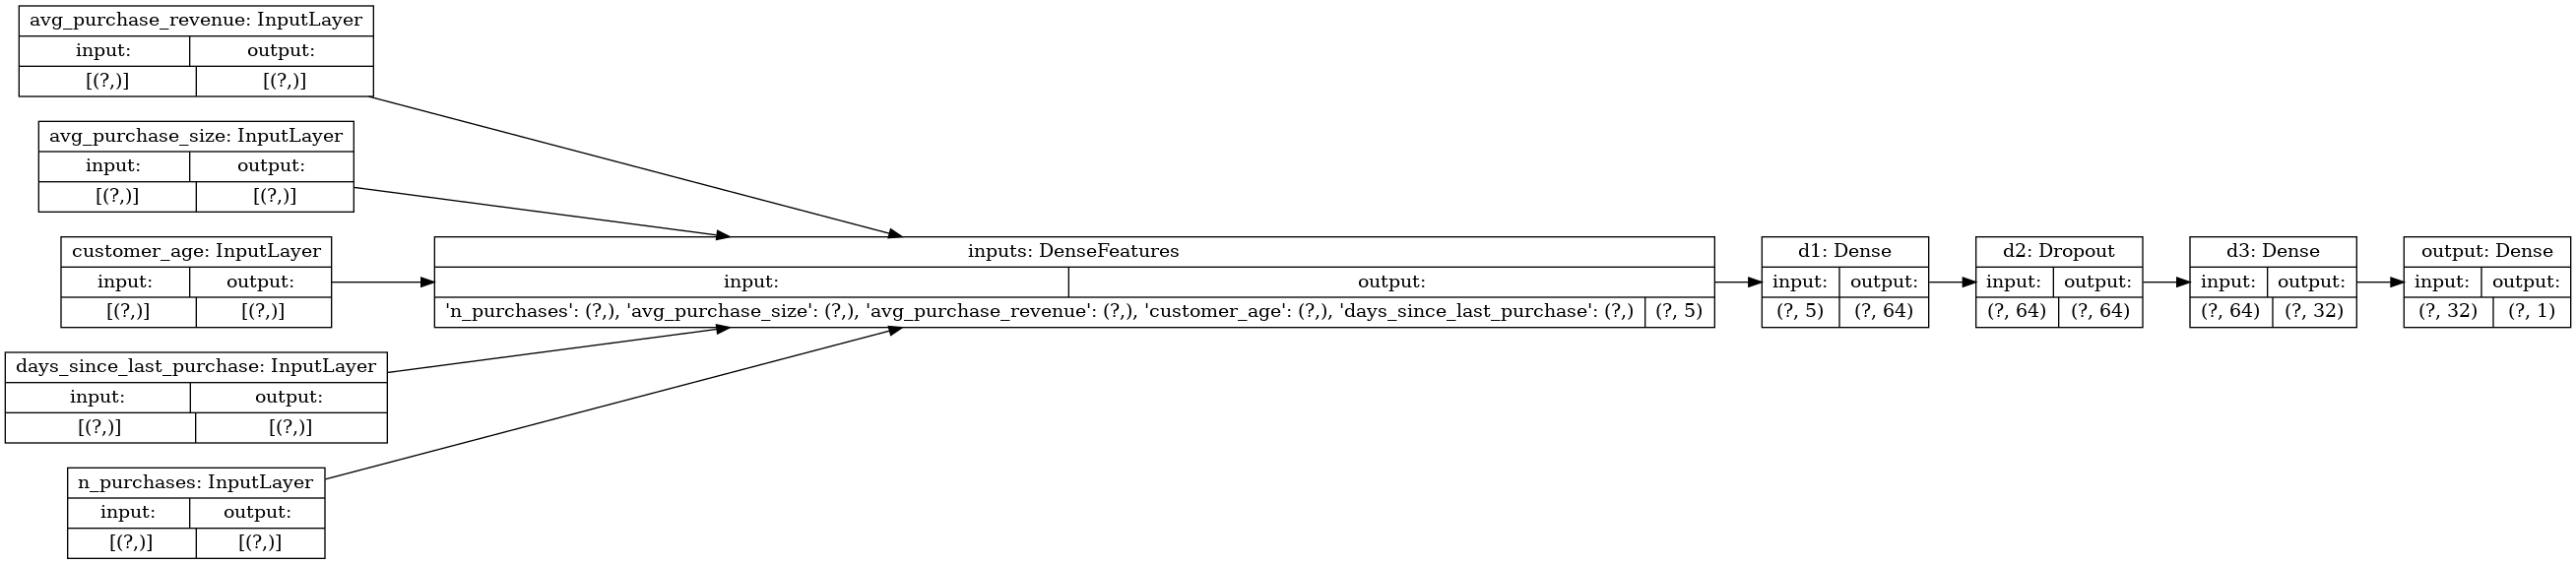

In [594]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [595]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./tmp/tensorboard-logs',
    histogram_freq=1)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoints',
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

In [ ]:
history = model.fit(trainds,
                    validation_data=evalds,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=N_CHECKPOINTS,
                    callbacks=[[tensorboard_callback,
                                earlystopping_callback,
                                checkpoint_callback]])

In [545]:
print(model.evaluate(evalds))

23/23 [==============================] - 0s 1ms/step - loss: 24844828.0000 - mae: 1228.9453 - mse: 24844828.0000 - rmse: 2534.6929
[24844828.0, 1228.9453125, 24844828.0, 2534.69287109375]


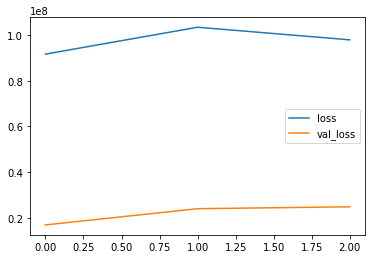

In [546]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot();

In [ ]:
test_results = model.predict(testds)

In [ ]:
test_results = pd.DataFrame({'actual': clv_test['target_monetary_value_3M'].to_numpy(), 'predicted': test_results}, columns=['actual', 'predicted'])

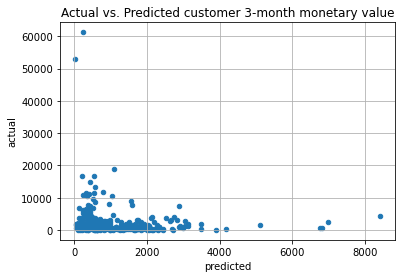

In [506]:
test_results.plot(kind='scatter',
              x='predicted', 
              y='actual',
             title='Actual vs. Predicted customer 3-month monetary value',
             grid=True);

## Create a managed Tabular dataset from BigQuery

[Vertex AI datasets]() can be used to train AutoML models or custom-trained models. The quality of your training data impacts the effectiveness of the models you create.

In [87]:
ds = aiplatform.TabularDataset.create(display_name="online-retail-clv", bq_source=f"bq://{PROJECT_ID}.online_retail.online_retail_clv_ml")

INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/617979904441/locations/us-central1/datasets/8346058514912772096/operations/177987018159030272
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/617979904441/locations/us-central1/datasets/8346058514912772096
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/617979904441/locations/us-central1/datasets/8346058514912772096')


'8346058514912772096'

## Containerize your model training code and push it Google Container Registry

### Create Dockerfile

In [33]:
%%writefile trainer/Dockerfile
# Specifies base image and tag.
# https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3

# Sets the container working directory.
WORKDIR /root

# Copies the requirements.txt into the container to reduce network calls.
COPY requirements.txt .
# Installs additional packages.
RUN pip3 install -U -r requirements.txt

# Copies the trainer code to the docker image.
COPY task.py /root/task.py

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python3", "task.py"]

Overwriting trainer/Dockerfile


### Write training script

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--model-dir', dest='model_dir',
                    default=os.getenv('AIP_MODEL_DIR'), type=str, help='Model dir.')
parser.add_argument('--data-format', dest='data-format',
                    default=os.getenv('AIP_DATA_FORMAT'), type=str, help="Tabular data format. Either 'csv' or 'bigquery'")
parser.add_argument('--training-data-uri', dest='training-data-uri',
                    default=os.getenv('AIP_TRAINING_DATA_URI'), type=str, help='Training data GCS or BQ URI.')
parser.add_argument('--validation-data-uri', dest='validation-data-uri',
                    default=os.getenv('AIP_VALIDATION_URI'), type=str, help='Validation data GCS or BQ URI.')
parser.add_argument('--test-data-uri', dest='test-data-uri',
                    default=os.getenv('AIP_TEST_URI'), type=str, help='Test data GCS or BQ URI.')

parser.add_argument('--learning-rate', dest='learning-rate', default=0.001, type=float, help='Learning rate.')
parser.add_argument('--epochs', dest='epochs', default=20, type=int, help='Number of epochs.')
parser.add_argument('--steps', dest='steps', default=100, type=int, help='Number of steps per epoch.')
args = parser.parse_args()

In [350]:
%%writefile trainer/task.py

import os
import tempfile
import tensorflow as tf
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession

# Model training constants.
# Virtual epochs design pattern:
# https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730
N_TRAIN_EXAMPLES = 2638
N_DEV_EXAMPLES = 353
STOP_POINT = 10.0
TOTAL_TRAIN_EXAMPLES = int(STOP_POINT * N_TRAIN_EXAMPLES)
BATCH_SIZE = 16
N_CHECKPOINTS = 10
STEPS_PER_EPOCH = (TOTAL_TRAIN_EXAMPLES // (BATCH_SIZE*N_CHECKPOINTS))


training_data_uri = os.environ["AIP_TRAINING_DATA_URI"]
validation_data_uri = os.environ["AIP_VALIDATION_DATA_URI"]
test_data_uri = os.environ["AIP_TEST_DATA_URI"]
data_format = os.environ["AIP_DATA_FORMAT"]


NUMERIC_FEATURES = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
]

CATEGORICAL_FEATURES = [
    "customer_country"
]

LABEL = "target_monetary_value_3M"


def caip_uri_to_fields(uri):
    """Helper function to parse BQ URI."""
    # Remove bq:// prefix.
    uri = uri[5:]
    project, dataset, table = uri.split('.')
    return project, dataset, table


def features_and_labels(row_data):
    """Helper feature and label mapping function for tf.data."""
    label = row_data.pop(LABEL)
    features = row_data
    return features, label


def read_bigquery(project, dataset, table):
    """TensorFlow IO BigQuery Reader."""
    tensorflow_io_bigquery_client = BigQueryClient()
    read_session = tensorflow_io_bigquery_client.read_session(
      parent="projects/" + project,
      project_id=project, 
      dataset_id=dataset,
      table_id=table,
      # Pass list of features and label to be selected from BQ.
      selected_fields=NUMERIC_FEATURES + [LABEL],
      # Provide output TensorFlow data types for features and label.
      output_types=[dtypes.int64, dtypes.float64, dtypes.float64, dtypes.int64, dtypes.int64] + [dtypes.float64],
      requested_streams=2)
    dataset = read_session.parallel_read_rows()
    transformed_ds = dataset.map(features_and_labels)
    return transformed_ds


training_ds = read_bigquery(*caip_uri_to_fields(training_data_uri)).prefetch(1).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE).repeat()
eval_ds = read_bigquery(*caip_uri_to_fields(validation_data_uri)).prefetch(1).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
test_ds = read_bigquery(*caip_uri_to_fields(test_data_uri)).prefetch(1).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)


feature_columns = {
    feature: tf.feature_column.numeric_column(feature)
    for feature in NUMERIC_FEATURES
}


# Create a custom RMSE evalution metric.
def rmse(y_true, y_pred):
    """"""
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model():
    """Build and compile a TensorFlow Keras model."""
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns.values()),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),        
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)    
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[['mae', 'mse', rmse]])
    
    return model

model = build_model()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=os.environ["AIP_MODEL_DIR"] + '/tensorboard-logs',
    histogram_freq=1)

# 
earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)

# Ensure your training job's resilience to VM restarts.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.environ["AIP_MODEL_DIR"] + '/checkpoints',
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

model.fit(training_ds,
          validation_data=eval_ds,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=N_CHECKPOINTS,
          callbacks=[[tensorboard_callback,
                      earlystopping_callback,
                      checkpoint_callback]])

print(model.evaluate(test_ds))

tmpdir = tempfile.mkdtemp()

# Export Keras model in TensorFlow SavedModel format.
model.save(tmpdir)

# Annotate and save TensorFlow SavedModel with Explainable metadata to GCS.
builder = SavedModelMetadataBuilder(tmpdir)
builder.save_model_with_metadata(os.environ["AIP_MODEL_DIR"])

Overwriting trainer/task.py


### Use Cloud Build to build and submit container to Google Cloud Container Registry

Next, you will use [Cloud Build](https://cloud.google.com/build) to build and upload your custom TensorFlow model container to [Google Cloud Container Registry](https://cloud.google.com/container-registry).

Cloud Build brings automation to your ML experimentation by enabling you to reliably build, test, and deploy your ML model code as part of a CI/CD workflow. Container Registry provides a centralized repository for you to store, manage, and secure your ML container images. This will allow you to securely share your and reproduce your work with others.

Note: this step will take about 5-8 minutes.

#### Create Cloudbuild YAML

In [11]:
cloudbuild_yaml = """steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', 'gcr.io/{PROJECT_ID}/online-retail-clv', '.' ]
images: ['gcr.io/{PROJECT_ID}/online-retail-clv']""".format(
    PROJECT_ID=PROJECT_ID
)

with open(f"trainer/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

#### Build and submit your container

In [ ]:
!gcloud builds submit --timeout=15m --config trainer/cloudbuild.yaml trainer

## Run a custom training job on Vertex AI

Use the `CustomTrainingJob` class to define the job, which takes the following parameters:

* `display_name`: The user-defined name of this training pipeline.
* `container_uri`: The URI of the training container image.
* `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model. You will use a Vertex prebuilt container.

Use the `run()` function to start training, which takes the following parameters:

* `replica_count`: The number of worker replicas.
* `model_display_name`: The display name of the Model if the script produces a managed Model.
* `machine_type`: The type of machine to use for training.
* `bigquery_destination`: The BigQuery URI where your created Tabular dataset gets written to.
* `predefined_split_column_name`: Since this lab leveraged BigQuery for data processing and splitting, this column is specified to indicate data splits.

The run function creates a training pipeline that trains and creates a Vertex `Model` object. After the training pipeline completes, the `run()` function returns the `Model` object.

Note: this `CustomContainerTrainingJob` will take about 20 minutes to provision resources and train your model.

In [ ]:
job = aiplatform.CustomContainerTrainingJob(
    display_name="online-retail-clv",
    container_uri=f"gcr.io/{PROJECT_ID}/online-retail-clv:latest",
    # https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
    model_serving_container_image_uri="gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-3:latest",
)

model = job.run(
    ds,
    replica_count=1,
    model_display_name="online-retail-clv-3M",
    bigquery_destination=f"bq://{PROJECT_ID}",
    predefined_split_column_name="data_split"
)

In [364]:
# Get path to saved model in GCS.
MODEL_DIR = model._gca_resource.artifact_uri

## Inspect model training performance with Vertex TensorBoard

[Vertex TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments) is Google Cloud's managed version of [TensorBoard](https://www.tensorflow.org/tensorboard) for ML experimental visualization. With Vertex TensorBoard you can track, visualize, and compare ML experiments and share them with your team. In addition to the powerful visualizations from open source TensorBoard, Vertex TensorBoard provides:

* A persistent, shareable link to your experiment's dashboard
* A searchable list of all experiments in a project
* Integrations with Vertex AI services for model training

In [ ]:
!gcloud beta ai tensorboards create \
--display-name=online-retail-clv --region=us-central1

In [362]:
TB_INSTANCE_NAME = 'projects/617979904441/locations/us-central1/tensorboards/6037391959838949376'
TB_EXPERIMENT_NAME = 'online-retail-clv'
TB_LOG_DIR = MODEL_DIR + '/tensorboard-logs'

In [ ]:
!tb-gcp-uploader --tensorboard_resource_name $TB_INSTANCE_NAME \
  --logdir= TB_LOG_DIR \
  --experiment_name=$TB_EXPERIMENT_NAME --one_shot=True

## Build the Explanation Metadata and Parameters

[**Vertex Explainable AI**](https://cloud.google.com/vertex-ai/docs/explainable-ai) integrates feature attributions into Vertex AI. Vertex Explainable AI helps you understand your model's outputs for classification and regression tasks. Vertex AI tells you how much each feature in the data contributed to the predicted result. You can then use this information to verify that the model is behaving as expected, recognize bias in your models, and get ideas for ways to improve your model and your training data.

You will retrieve these feature attributions to 

In [366]:
loaded = tf.keras.models.load_model(MODEL_DIR)

In [367]:
serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]

serving_output = list(loaded.signatures["serving_default"].structured_outputs.keys())[0]

feature_names = [
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase"
]

In [368]:
# Specify sampled Shapley feature attribution method with path_count parameter 
# controlling the number of feature permutations to consider when approximating the Shapley values.
explain_params = aiplatform.explain.ExplanationParameters(
    {"sampled_shapley_attribution": {"path_count": 10}}
)

In [369]:
# https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/ExplanationSpec
input_metadata = {
    "input_tensor_name": serving_input,
    "encoding": "BAG_OF_FEATURES",
    "modality": "numeric",
    "index_feature_mapping": feature_names,
}

# 
output_metadata = {"output_tensor_name": serving_output}

input_metadata = aiplatform.explain.ExplanationMetadata.InputMetadata(input_metadata)
output_metadata = aiplatform.explain.ExplanationMetadata.OutputMetadata(output_metadata)

explain_metadata = aiplatform.explain.ExplanationMetadata(
    inputs={"features": input_metadata}, outputs={"medv": output_metadata}
)

## Deploy a Vertex model endpoint

Before you use your model to make predictions, you need to deploy it to an `Endpoint` object. When you deploy a model to an `Endpoint`, you associate physical (machine) resources with that model to enable it to serve online predictions. Online predictions have low latency requirements; providing resources to the model in advance reduces latency. You can do this by calling the deploy function on the `Model` resource. This will do two things:

1. Create an `Endpoint` resource for deploying the `Model` resource to.
2. Deploy the `Model` resource to the `Endpoint` resource.

The `deploy()` function takes the following parameters:

* `deployed_model_display_name`: A human readable name for the deployed model.
* `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs. If only one model, then specify as { "0": 100 }, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
* `machine_type`: The type of machine to use for training.
* `accelerator_type`: The hardware accelerator type.
* `accelerator_count`: The number of accelerators to attach to a worker replica.
* `starting_replica_count`: The number of compute instances to initially provision.
* `max_replica_count`: The maximum number of compute instances to scale to. In this lab, only one instance is provisioned.
* `explanation_parameters`: 
* `explanation_metadata`:

Note: this can take 5-10 minutes to provision prediction resources for your model.

In [ ]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="n1-standard-2",
    explanation_parameters=explain_params,
    explanation_metadata=explain_metadata)

## Get online prediction and explanation from deployed model

Finally, you will use your `Endpoint` to retrieve predictions and feature attributions.

In [373]:
# actual: 11651.589999999997
test_instance_dict = {
    "n_purchases": 18,
    "avg_purchase_size": 196.16666666666666,
    "avg_purchase_revenue": 456.66222222222228,
    "customer_age": 271,
    "days_since_last_purchase": 1,
}

To request predictions, you call the `predict()` method.

In [374]:
endpoint.predict([test_instance_dict])

Prediction(predictions=[[2805.64331]], deployed_model_id='4087562019606102016', explanations=None)

To retrieve explanations (predictions + feature attributions), call the `explain()` method.

In [379]:
explanations = endpoint.explain([test_instance_dict])

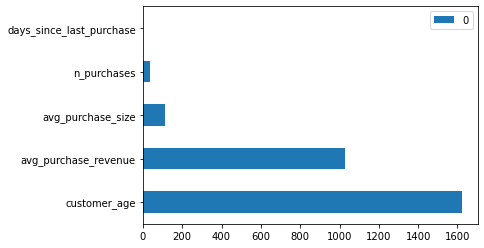

In [408]:
pd.DataFrame.from_dict(explanations.explanations[0].attributions[0].feature_attributions, orient='index').plot(kind='barh');

## Next steps

Congratulations! In this lab, you walked through a machine learning experimentation workflow using Google Cloud's BigQuery as a data source and Vertex AI machine learning services to train and deploy a TensorFlow model to predict customer lifetime value.

This lab demonstrated a simple way to predict customer 3-month CLV monetary value. Additional factors to consider when using CLV to inform interventions include customer acquisition costs and discount rates to arrive at the present value of future customer cash flows. 

## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.